# Prediction of client leave

The notebook contains the process of data processing, testing hypotheses, building and tuning hyperparameters of machine learning models to solve the “Prediction of client leave” track of the Sber company track as part of the IT Purple Hack Hackathon

To install all the necessary components, run requirements.txt

As part of the hackathon, it was proposed to solve the problem of binary classification of clients using anonymized data. The final metric by which the models will be evaluated: ROC-AUC, however, to solve business problems, the notebook provides other metrics for binary classification: Precision, Recall and F1

Content:

0. Imports;
1. Data Exploring;
2. Feature selection; 
3. Modeling and Testing hypotheses; 
4. Results;
5. Business analysis of obtained solutions; 
6. Conclusions;

## All necessary imports 

In [3]:
from tqdm import tqdm
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna


from catboost import CatBoostClassifier, Pool
from catboost.utils import get_gpu_device_count

from sklearn.metrics import roc_auc_score, classification_report, recall_score, precision_score, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

In [8]:
# Check if GPU is available for training
is_GPU_available = get_gpu_device_count()
print(f'I see {is_GPU_available} GPU devices')

I see 1 GPU devices


## Read the Data

As part of the work, an EDA was carried out by the project team.

Features containing gaps were discarded because they contained too many missing values

For categorical features, a certain threshold was set. A feature is considered categorical if the number of unique values is less than or equal to the threshold value.

In [5]:
df = pd.read_parquet('/kaggle/input/it-purple-sber-hack/archive/train_ai_comp_final_dp.parquet', engine='pyarrow')
df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})

In [10]:
df.head(5)

,id,target,sample_ml_new,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1,1761,1759,85,105469,191,46,0,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1,1761,1759,120,105610,144,71,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,890,1759,141,105227,191,11,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1,1599,966,30,102441,191,8,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1,1761,1759,85,104006,191,2,0,...,0,0,7642,0,0,0,0,0,0,7642


In [6]:
cols_with_nulls = df.columns[df.isnull().any()]
df[cols_with_nulls].describe()

,feature642,feature756
count,204291.000000,0.0
mean,0.019423,NaN
std,0.138008,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN
max,1.000000,NaN


In [7]:
df.drop(cols_with_nulls, axis=1, inplace=True)

Let's look at the distribution of the target variable to detect potential class imbalance

<Axes: xlabel='target', ylabel='count'>

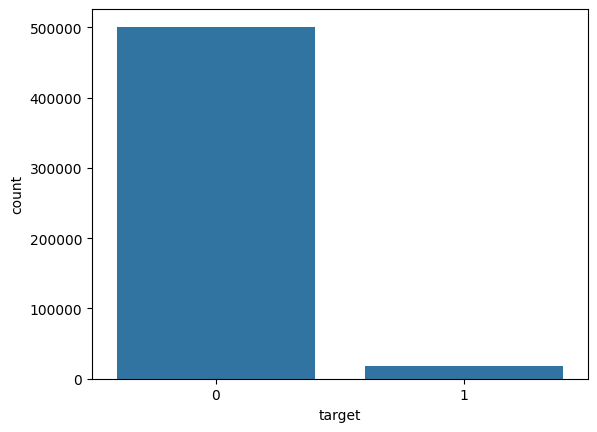

In [14]:
sns.countplot(x='target', data=df)

In [15]:
df.target.value_counts()

target
0    501078
1     18537
Name: count, dtype: int64

The data is provided revealed a strong class imbalance. This fact will need to be taken into account when building future models.

## Feature Selection

Many different heuristics have been used to select features:
1) Principal component analysis (PCA)
2) Variance inflation factor (VIF)
3) Selection of features according to the meta-model based on the importance of the features for the meta-model
4) Selection of features based on SHAP values

Due to the fact that the data is anonymized, it is not possible to conduct a more thorough selection of features based on the meaning of the information. Therefore, to build basic models, we chose the option of selecting features based on the meta model and on SHAP values.

To eliminate the imbalance when building the metamodel, RandomUnderSampler was used.

The gradient boosting model of the Catboost library from Yandex was chosen as a metamodel, as one of the most flexible and powerful solutions in classical machine learning at the moment

In [8]:
# Split the data for the meta-model
X, y = df.drop(['id', 'target', 'sample_ml_new'], axis=1), df.target
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [11]:
# selecting categorical features based on the selected threshold
cat = [x for x in X.columns if X_train_rus[x].nunique() <= 10]

In [12]:
# The model can be either trained or loaded from the drive
try: 
    selector = CatBoostClassifier()
    selector.load_model('Models\\TheSelector', format='cbm')
    print('Loaded succesfully')
except:
    print("Saved Model doesn't exists in the PATH")

Saved Model doesn't exists in the PATH


In [30]:
selector = CatBoostClassifier(
    iterations = 1400,
    depth=5,
    learning_rate=0.03,
    eval_metric='AUC',
    cat_features = cat,
    thread_count=6,
    early_stopping_rounds=200,
    task_type='GPU' if is_GPU_available > 0 else 'CPU'
)

selector.fit(X_train_rus, y_train_rus, eval_set=(X_val, y_val), verbose=100)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7043444	best: 0.7043444 (0)	total: 452ms	remaining: 10m 31s

100:	test: 0.7425618	best: 0.7425618 (100)	total: 21.9s	remaining: 4m 41s

200:	test: 0.7500986	best: 0.7500986 (200)	total: 40.2s	remaining: 3m 59s

300:	test: 0.7533873	best: 0.7533956 (299)	total: 52.7s	remaining: 3m 12s

400:	test: 0.7547329	best: 0.7548051 (390)	total: 1m 5s	remaining: 2m 42s

500:	test: 0.7553070	best: 0.7553252 (492)	total: 1m 17s	remaining: 2m 19s

600:	test: 0.7558631	best: 0.7558667 (596)	total: 1m 30s	remaining: 1m 59s

700:	test: 0.7563165	best: 0.7563317 (695)	total: 1m 42s	remaining: 1m 41s

800:	test: 0.7567687	best: 0.7567961 (781)	total: 1m 59s	remaining: 1m 29s

900:	test: 0.7567473	best: 0.7567961 (781)	total: 2m 16s	remaining: 1m 15s

1000:	test: 0.7567976	best: 0.7568194 (913)	total: 2m 37s	remaining: 1m 2s

1100:	test: 0.7565622	best: 0.7568194 (913)	total: 2m 59s	remaining: 48.8s

bestTest = 0.756819427

bestIteration = 913

Shrink model to first 914 iterations.


In [31]:
# Save the model
try:
    selector.save_model('Models\TheSelector',  format="cbm", export_parameters=None, pool=None)
    print('Saved!')
except:
    print("Something goes wrong... Perhaps the folder doen't exist")

Saved!


In [32]:
# Save the feature importance
df_imp = pd.DataFrame({
    'name': X.columns,
    'imp': selector.get_feature_importance()
}).sort_values('imp', ascending=False)

In [33]:
sorted_cols = df_imp['name'].tolist()

Due to the complexity of data interpretation, the following feature selection method was chosen: iteratively sort through a certain top feature by importance, train a classifier without tuning hyperparameters, and compare metrics on the trained model. A baseline was chosen as a model.

In [36]:
models_auc = []

for cut in tqdm([15, 30, 50, 75, 100, 150, 200, 250, 300, 500, 1000]):
    
    print('current cut is ', cut)
    
    good = sorted_cols[:cut]
    cat_ = [x for x in cat if x in X_train_rus[good].columns] # оставшиеся категориальные
    

    print(f'CATBOOST with cut = {cut}')
        
    # с rus
    model_cb_rus = CatBoostClassifier(iterations=1000, depth=5, cat_features=cat_, eval_metric='AUC', task_type='GPU' if is_GPU_available > 0 else 'CPU',)
    model_cb_rus.fit(X_train_rus[good], y_train_rus, eval_set=(X_val[good], y_val), silent=True)
    predictions = model_cb_rus.predict_proba(X_val[good])[:, 1]
    auc = roc_auc_score(y_val, predictions)
    models_auc.append(auc)
    print('#'*50)
    print(f'Model with {cut} columns has been trained')
    print(f'ROC_AUC = {auc}')
    print('#'*50)

  0%|          | 0/11 [00:00<?, ?it/s]

current cut is  15

CATBOOST with cut = 15


Default metric period is 5 because AUC is/are not implemented for GPU

  9%|▉         | 1/11 [00:45<07:30, 45.04s/it]

##################################################

Model with 15 columns has been trained

ROC_AUC = 0.7429519004528853

##################################################

current cut is  30

CATBOOST with cut = 30


Default metric period is 5 because AUC is/are not implemented for GPU

 18%|█▊        | 2/11 [01:29<06:42, 44.71s/it]

##################################################

Model with 30 columns has been trained

ROC_AUC = 0.7513724711246315

##################################################

current cut is  50

CATBOOST with cut = 50


Default metric period is 5 because AUC is/are not implemented for GPU

 27%|██▋       | 3/11 [02:34<07:12, 54.09s/it]

##################################################

Model with 50 columns has been trained

ROC_AUC = 0.7567735859413374

##################################################

current cut is  75

CATBOOST with cut = 75


Default metric period is 5 because AUC is/are not implemented for GPU

 36%|███▋      | 4/11 [03:23<06:03, 51.95s/it]

##################################################

Model with 75 columns has been trained

ROC_AUC = 0.7569711656434188

##################################################

current cut is  100

CATBOOST with cut = 100


Default metric period is 5 because AUC is/are not implemented for GPU

 45%|████▌     | 5/11 [04:25<05:33, 55.63s/it]

##################################################

Model with 100 columns has been trained

ROC_AUC = 0.7576329624907958

##################################################

current cut is  150

CATBOOST with cut = 150


Default metric period is 5 because AUC is/are not implemented for GPU

 55%|█████▍    | 6/11 [05:26<04:47, 57.49s/it]

##################################################

Model with 150 columns has been trained

ROC_AUC = 0.7581869721961664

##################################################

current cut is  200

CATBOOST with cut = 200


Default metric period is 5 because AUC is/are not implemented for GPU

 64%|██████▎   | 7/11 [06:18<03:41, 55.47s/it]

##################################################

Model with 200 columns has been trained

ROC_AUC = 0.7569093030432738

##################################################

current cut is  250

CATBOOST with cut = 250


Default metric period is 5 because AUC is/are not implemented for GPU

 73%|███████▎  | 8/11 [07:12<02:45, 55.30s/it]

##################################################

Model with 250 columns has been trained

ROC_AUC = 0.7562568574565747

##################################################

current cut is  300

CATBOOST with cut = 300


Default metric period is 5 because AUC is/are not implemented for GPU

 82%|████████▏ | 9/11 [08:13<01:53, 56.83s/it]

##################################################

Model with 300 columns has been trained

ROC_AUC = 0.7566794380733246

##################################################

current cut is  500

CATBOOST with cut = 500


Default metric period is 5 because AUC is/are not implemented for GPU

 91%|█████████ | 10/11 [09:32<01:03, 63.66s/it]

##################################################

Model with 500 columns has been trained

ROC_AUC = 0.7553712871484349

##################################################

current cut is  1000

CATBOOST with cut = 1000


Default metric period is 5 because AUC is/are not implemented for GPU

100%|██████████| 11/11 [13:07<00:00, 71.62s/it] 

##################################################

Model with 1000 columns has been trained

ROC_AUC = 0.7565063886068676

##################################################


In [37]:
print(models_auc)
np.argmax(np.array(models_auc)) # Use 150 features then 

[0.7429519004528853, 0.7513724711246315, 0.7567735859413374, 0.7569711656434188, 0.7576329624907958, 0.7581869721961664, 0.7569093030432738, 0.7562568574565747, 0.7566794380733246, 0.7553712871484349, 0.7565063886068676]


5

In [38]:
features = sorted_cols[:150] 

In [47]:
X, y = X[features], y
cat = [x for x in X.columns if X_train_rus[x].nunique() <= 10]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## Testing hypotheses
The author of the notebook tested the following hypotheses:

1) The influence of using model class weight parameters on the quality of classification
2) The influence of oversampling by various methods (SMOTE, ADASYN, SMOTENC) on the quality of classification

In [75]:
smote = SMOTE(random_state=42) 
smotenc = SMOTENC(random_state=42, categorical_features=cat) 
adasyn = ADASYN(random_state=42)
rus = RandomUnderSampler(random_state=42)

In [49]:
X_smote, y_smote = smote.fit_resample(X_train, y_train) 
X_smotenc, y_smotenc = smotenc.fit_resample(X_train, y_train)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [77]:
train_Pool = Pool(X_train, y_train, cat_features=cat)
train_Pool_smote = Pool(X_smote, y_smote, cat_features=cat)
train_Pool_smotenc = Pool(X_smotenc, y_smotenc, cat_features=cat)
train_Pool_adasyn = Pool(X_adasyn, y_adasyn, cat_features=cat)
train_Pool_rus = Pool(X_train_rus, y_train_rus, cat_features=cat)

test_Pool =  Pool(X_test, y_test, cat_features=cat)

In [78]:
smote_data = [train_Pool_smote, test_Pool]
smotenc_data = [train_Pool_smotenc, test_Pool]
adasyn_data = [train_Pool_adasyn, test_Pool]
train_data = [train_Pool, test_Pool]
rus_data = [train_Pool_rus, test_Pool]

In [53]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights

array([ 0.51849712, 14.01561741])

In [62]:
model_no_weighted = CatBoostClassifier(
    iterations=1000,
    depth=10,
    grow_policy='Lossguide',
    task_type='GPU' if is_GPU_available > 0 else 'CPU',
    min_data_in_leaf=100,
    loss_function='CrossEntropy',
    verbose=200
)

model_weighted = CatBoostClassifier(
    iterations=1000,
    depth=10,
    task_type='GPU' if is_GPU_available > 0 else 'CPU',
    grow_policy='Lossguide',
    min_data_in_leaf=100,
    class_weights = class_weights,
    verbose=200
)

In [79]:
report = {}
match_d = {0: 'smote', 1: 'smotenc', 2: 'adasyn', 3: 'RuS', 4: 'nothing'}

for i, (train, test) in enumerate([smote_data, smotenc_data, adasyn_data, rus_data, train_data]):
    
    model_1 = model_no_weighted
    model_2 = model_weighted
    
    model_1.fit(train)
    
    predictions = model_1.predict(test)
    proba = model_1.predict_proba(test)[:, 1]
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)
    report[match_d[i]] = {'no_weights' : [precision, recall, f1, roc_auc]}
    
    print(f'{match_d[i]} no_weights model has trained')
    
    model_2.fit(train)
    
    predictions = model_2.predict(test)
    proba = model_2.predict_proba(test)[:, 1]
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)
    report[match_d[i]]['weighted'] = [precision, recall, f1, roc_auc]
    
    print(f'{match_d[i]} weighted model has trained')
    
print('training is over')

0:	learn: 0.6468202	total: 73.7ms	remaining: 1m 13s

200:	learn: 0.1055474	total: 13.8s	remaining: 54.8s

400:	learn: 0.0855023	total: 26.9s	remaining: 40.2s

600:	learn: 0.0798010	total: 37.9s	remaining: 25.2s

800:	learn: 0.0764623	total: 45.1s	remaining: 11.2s

999:	learn: 0.0737510	total: 52.1s	remaining: 0us

smote no_weights model has trained

Learning rate set to 0.02351

0:	learn: 0.6371070	total: 49.7ms	remaining: 49.7s

200:	learn: 0.0524084	total: 12.9s	remaining: 51.2s

400:	learn: 0.0455219	total: 26.4s	remaining: 39.4s

600:	learn: 0.0425364	total: 39.1s	remaining: 25.9s

800:	learn: 0.0403025	total: 51.4s	remaining: 12.8s

999:	learn: 0.0383024	total: 1m 3s	remaining: 0us

smote weighted model has trained

0:	learn: 0.6724756	total: 69.8ms	remaining: 1m 9s

200:	learn: 0.1069437	total: 12.8s	remaining: 50.8s

400:	learn: 0.0864803	total: 20.9s	remaining: 31.2s

600:	learn: 0.0803720	total: 28.5s	remaining: 18.9s

800:	learn: 0.0771173	total: 35.6s	remaining: 8.86s

999:	

In [82]:
df1 = pd.DataFrame(report['smote'], index=['Precision', 'Recall', 'F1', 'roc_auc']).rename(columns={"no_weights": "no_weights_SMOTE", "weighted": "weighted_SMOTE"})
df2 = pd.DataFrame(report['smotenc'], index=['Precision', 'Recall', 'F1', 'roc_auc']).rename(columns={"no_weights": "no_weights_SMOTENC", "weighted": "weighted_SMOTENC"})
df3 = pd.DataFrame(report['adasyn'], index=['Precision', 'Recall', 'F1', 'roc_auc']).rename(columns={"no_weights": "no_weights_ADASYN", "weighted": "weighted_ADASYN"})
df4 = pd.DataFrame(report['RuS'], index=['Precision', 'Recall', 'F1', 'roc_auc']).rename(columns={"no_weights": "no_weights_RUS", "weighted": "weights_no_sampling_RUS"})
df5 = pd.DataFrame(report['nothing'], index=['Precision', 'Recall', 'F1', 'roc_auc']).rename(columns={"no_weights": "no_weights_no_sampling", "weighted": "weights_no_sampling"})

df_report = pd.concat([df1, df2, df3, df4, df5], axis=1, join="inner")
df_report.T

,Precision,Recall,F1,roc_auc
no_weights_SMOTE,"[0.9653136388806614, 0.2504317789291883]","[0.9971134596582709, 0.026211135213304412]","[0.9809559018383232, 0.047455408280150546]",0.719751
weighted_SMOTE,"[0.9809319089401366, 0.0724414046209025]","[0.7041495680166009, 0.6279826464208242]","[0.8198093556655129, 0.1298982949446605]",0.727724
no_weights_SMOTENC,"[0.9651750259047349, 0.23818897637795275]","[0.997426057345048, 0.021872740419378162]","[0.9810355542472116, 0.040066225165562915]",0.714138
weighted_SMOTENC,"[0.9807850467289719, 0.07110565613173775]","[0.6979840774710182, 0.6283441793203182]","[0.8155646135852311, 0.12775419446128966]",0.723067
no_weights_ADASYN,"[0.9652954394730573, 0.24738675958188153]","[0.9971267616874955, 0.02566883586406363]","[0.9809529417922948, 0.046511627906976744]",0.719751
weighted_ADASYN,"[0.9808675481326838, 0.07212637705258781]","[0.7030987077078609, 0.6272595806218366]","[0.8190742577325978, 0.1293762350397077]",0.726912
no_weights_RUS,"[0.9828430459877118, 0.07611678530898587]","[0.7021941697205909, 0.6668474331164136]","[0.819147079019137, 0.13663722058632888]",0.7467
weights_no_sampling_RUS,"[0.9934384046317144, 0.038691748610517315]","[0.10271161865742619, 0.9815618221258134]","[0.1861746374278171, 0.07444883185258308]",0.742555
no_weights_no_sampling,"[0.964661113749246, 0.49019607843137253]","[0.9998270736200807, 0.004519161243673174]","[0.9819293438323639, 0.008955758552749419]",0.753341
weights_no_sampling,"[0.9803988452290823, 0.08899349921542254]","[0.7837622129255818, 0.57411424439624]","[0.8711217889484384, 0.15409995147986413]",0.749518


No significant increase in the main metric was found during oversampling; however, this approach allows, with the correct choice of the threshold set of predictions, to obtain the values of the secondary metrics necessary for the business. This is described in more detail in the presentation to the project

## Model Building

Optuna is a framework for automatically finding optimal hyperparameters for machine learning models. She selects these parameters by trial and error. We used this framework to select optimal hyperparameters for the model. The following cells describe the procedure for setting up the hyperparameter selection process

### Baseline

In [ ]:
def objective(trial):
    parameters = {
        "iterations": trial.suggest_int('iterations', 1000, 2500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "grow_policy": trial.suggest_categorical("grow_policy", ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }   

    model = CatBoostClassifier(**parameters, task_type='GPU' if is_GPU_available > 0 else 'CPU', silent=True)
    model.fit(X_train_rus, y_train_rus)
    predictions = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, predictions)
    return auc

As a result of executing the code, a model with the following hyperparameters was obtained:

'iterations': 1691,  
'learning_rate': 0.007769028657632914,  
'depth': 9,  
'min_data_in_leaf': 42,  
'grow_policy': 'Lossguide' 
    

In [67]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

[I 2024-03-14 00:53:09,994] A new study created in memory with name: no-name-169bc6ac-f263-4c7f-8411-a94760c5c974


In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)

In [73]:
try:
    parameters = study.best_params
except:
    parameters = {
        'iterations': 1691,  
        'learning_rate': 0.007769028657632914,  
        'depth': 9,  
        'min_data_in_leaf': 42,  
        'grow_policy': 'Lossguide'
        }

test = pd.read_parquet('test_sber.parquet')
model = CatBoostClassifier(**parameters, task_type='GPU' if is_GPU_available > 0 else 'CPU', silent=True)
model.fit(X_train, y_train)

## Making a baseline submission

In [74]:
test = pd.read_parquet('test_sber.parquet')
predictions = model.predict_proba(test[features])[:, 1]
binary_labels = model.predict(test[features])

submission = pd.read_csv("sample_submission.csv")

submission["target_prob"] = predictions
submission["target_bin"] = binary_labels

submission.to_csv("submission_Stranger_OPTUNA.csv", index=False)

## Max Roc_AUC Model obtaining 

During the brainstorming, a team member suggested additionally encoding and scaling the values, and then train the model on the obtained data. As a result, we received a model with the highest target metric of $\color{#FFA500}ROC-AUC = 0.77222$. The following presents the process of preparing data and obtaining such a model.

In [83]:
X = pd.read_parquet('train_ai_comp_final_dp.parquet', engine='pyarrow')
y = X["target"]
X.drop(columns = ["sample_ml_new", "target", "id"], inplace = True)
X = X[features]

test = pd.read_parquet('test_sber.parquet', engine='pyarrow')
ids = test.id
test.drop(columns = ["sample_ml_new", "id"], inplace = True)
cat_cols = [col for col in X.columns if X[col].nunique() <= 10]
num_cols = [col for col in X.columns if col not in cat_cols]


label_encoder = LabelEncoder()
for col in cat_cols:
    test[col] = label_encoder.fit_transform(test[col])

scaler = StandardScaler()
test[num_cols] = scaler.fit_transform(test[num_cols])

label_encoder = LabelEncoder()
for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=1)

In [ ]:
def objective(trial):
    parameters = {
        "iterations": trial.suggest_int('iterations', 1500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 150),
        "grow_policy": trial.suggest_categorical("grow_policy", ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }   

    model = CatBoostClassifier(**parameters, task_type='GPU', silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predictions)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)

As a result of executing the code, a model with the following hyperparameters was obtained:

'iterations': 1843,  
'learning_rate': 0.010850773174276306,  
'depth': 8,  
'min_data_in_leaf': 66,  
'grow_policy': 'Depthwise'  

In [86]:
try:
    parameters = study.best_params
except:
    parameters = {
        'iterations': 1843,  
        'learning_rate': 0.010850773174276306,  
        'depth': 8,  
        'min_data_in_leaf': 66,  
        'grow_policy': 'Depthwise'  
        }

model = CatBoostClassifier(**parameters, task_type='GPU', class_weights=class_weights, silent=True)
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict_proba(test[features])[:, 1]
binary_labels = model.predict(test[features])

submission = pd.read_csv("sample_submission.csv")

submission["target_prob"] = predictions
submission["target_bin"] = binary_labels

submission.to_csv("submission_Stranger_OPTUNA_ENCODED.csv", index=False)

## Business analysis of obtained solutions 

In the process of analyzing the models, we discovered that the resulting models, despite the fact that the main metric for them is within close limits of the main indicators, they show completely different classification results from the point of view of business logic

During the analysis of the technical specifications and available cases, the project team formulated the project task in terms of business logic:
The goal of the project is to develop a system that can provide the best ratio of correctly classified potential churn customers to false positives while maximizing the number of correctly classified potential churn customers. In other words, in our opinion, the most important metrics for this task are, in descending order of importance: ROC_AUC, recall and f1_score for the positive class.

We assume that it is important for a business to retain a client who is at risk. This can be achieved by many methods, but the most popular and most effective method of maintaining customer loyalty is improving conditions for it using various methods: providing additional privileges, bonuses, gifts, and so on.
Of course, resources for this retention are limited; moreover, the amount of available resources, especially nowadays, can change rapidly due to external and internal factors.

In this regard, within the existing SBER ecosystem, we offer our own approach “Strategically adjustable model for bank churn prediction”, which allows you to flexibly balance between different customer retention strategies.

Our idea is to use a machine learning model containing $1 ... K$ classification submodels trained for different sensitivities. Depending on the chosen strategy (examples of strategies: **conservative** (low sensitivity, we miss a lot of potentially leaving clients, but save resources), **liberal** (50:50), **greedy** (we try to classify as much as possible, perhaps for a lower “price” of bonuses) and their variations) will produce different results containing different numbers of customers that need to be retained.

You can adjust the sensitivity of the model both during its training and after, changing the parameter of the threshold probability value necessary to make a decision on classifying an object as positive. Below is an example of how such models could be configured.

In [101]:
# We'll use our baseline as an example

X, y = df.drop(['id', 'target', 'sample_ml_new'], axis=1), df.target
X = X[features
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

parameters = {
    'iterations': 1691,  
    'learning_rate': 0.007769028657632914,  
    'depth': 9,  
    'min_data_in_leaf': 42,  
    'grow_policy': 'Lossguide'
    }

model = CatBoostClassifier(**parameters, task_type='GPU' if is_GPU_available > 0 else 'CPU', silent=True)

model.fit(X_train_rus, y_train_rus)

In [102]:
predictions = model.predict(X_val)
pred_probas = model.predict_proba(X_val)[:, 1]
print(classification_report(y_val, predictions))
roc_auc_score(y_val, pred_probas)

              precision    recall  f1-score   support



           0       0.98      0.70      0.82    100216

           1       0.08      0.69      0.14      3707



    accuracy                           0.70    103923

   macro avg       0.53      0.69      0.48    103923

weighted avg       0.95      0.70      0.80    103923




0.7602369575000976

Better F1-score (0.20):

In [ ]:
good_cols = sorted_cols[:40]

X_train, X_test = X_train[good_cols], X_val[good_cols]

model = CatBoostClassifier(
        iterations = 2500,
        depth=4,
        learning_rate=0.03,
        eval_metric='AUC',
        early_stopping_rounds=400,
        silent=True
    )

model.fit(X_train, y_train)

model.set_probability_threshold(binclass_probability_threshold=0.92)

y_pred = model.predict_proba(X_test)
y_pred_bin = model.predict(X_test)

print(classification_report(y_test, y_pred_bin))
roc_auc_score(y_test, y_pred)

In [108]:
thresh_df = pd.DataFrame(
    {
        'precision':[], 
        'recall':[], 
        'f1_score':[],
        'ROC_AUC':[],
        'threshold':[],
    }
)

for i in np.linspace(0, 1, 21)[1:-1]:
    model.set_probability_threshold(np.round(i, 3))
    prediction = model.predict(X_val)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, prediction)
    auc = roc_auc_score(y_val, prediction)
    thresh_df.loc[len(thresh_df)] = [precision[1], recall[1], f1_score[1], auc, i]

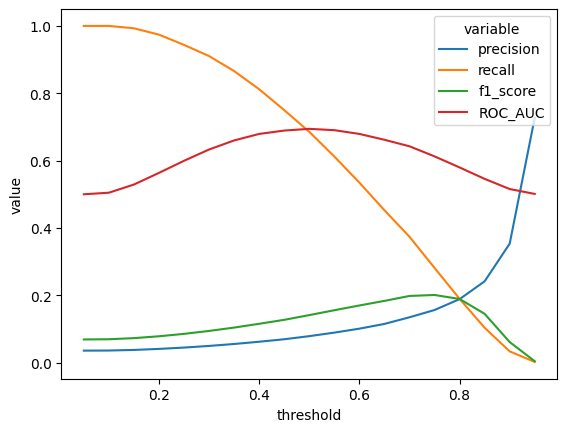

In [109]:
sns.lineplot(data=pd.melt(thresh_df, ['threshold']), x='threshold',  y='value', hue='variable');